# **Import libraries**

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import keras
import random
from keras import layers
import tensorflow as tf
from keras.utils import pad_sequences
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Use GPU device**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **DNA Sequence Classification**

# Data Preprocessing

In [4]:
#
# Load data from file path
#
def read_data(path):
  f = open(path)
  text = f.read()
  datas = re.split('\n\n',text)
  for i in range(len(datas)):
      x = re.split('\n', datas[i])
      dna_sequence = ''
      for j in range(1, len(x)):
          dna_sequence += x[j]
      datas[i] = dna_sequence
  return datas

In [5]:
#
# Convert data from character to number
#
mapping = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
def data_preprocessing(data):
    results = []
    for row in data:
        check = False
        arr = []
        for i in range(len(row)):
            if(row[i] not in mapping.keys()):
                check = True
                break
            arr.append(mapping[row[i]])
        if(check == False and 500 <= len(arr) <= 30000):
            results.append(arr)
    return results


In [14]:
#
# Reading data
#
mers_data = read_data('/kaggle/input/dna-sequence/NEW_MERS.fasta')
sars_data = read_data('/kaggle/input/dna-sequence/NEW_SARS.fasta')
covid_data = read_data('/kaggle/input/dna-sequence/COVID-19-2.fasta')
influenza_data = read_data('/kaggle/input/new-dna-sequence/influenza.fasta')

In [9]:
#
# Reading data
#
mers_data = read_data('/kaggle/input/new-dna-sequence/MERS.fasta')
sars_data = read_data('/kaggle/input/new-dna-sequence/SARS.fasta')
covid_data = read_data('/kaggle/input/new-dna-sequence/COVID.fasta')
influenza_data = read_data('/kaggle/input/new-dna-sequence/influenza.fasta')

In [15]:
#
# Encoding data
#
mers_encoding = data_preprocessing(mers_data)
sars_encoding = random.sample(data_preprocessing(sars_data), 2500)
covid_encoding = data_preprocessing(covid_data)
# dengue_encoding = data_preprocessing(dengue_data)
influenza_encoding = data_preprocessing(influenza_data)
# hepatitis_encoding = data_preprocessing(hepatitis_data)

In [ ]:
mers_data = pd.DataFrame({"dna": mers_encoding})
sars_data = pd.DataFrame({"dna": sars_encoding})
covid_data = pd.DataFrame({"dna": covid_encoding})
dengue_data = pd.DataFrame({"dna": dengue_encoding})

In [11]:
mers_data = pd.DataFrame({"dna": mers_encoding})
sars_data = pd.DataFrame({"dna": sars_encoding})
covid_data = pd.DataFrame({"dna": covid_encoding})
influenza_data = pd.DataFrame({"dna": influenza_encoding})

In [12]:
mers_data['length'] = mers_data['dna'].apply(lambda x: len(x))
sars_data['length'] = sars_data['dna'].apply(lambda x: len(x))
covid_data['length'] = covid_data['dna'].apply(lambda x: len(x))
influenza_data['length'] = influenza_data['dna'].apply(lambda x: len(x))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

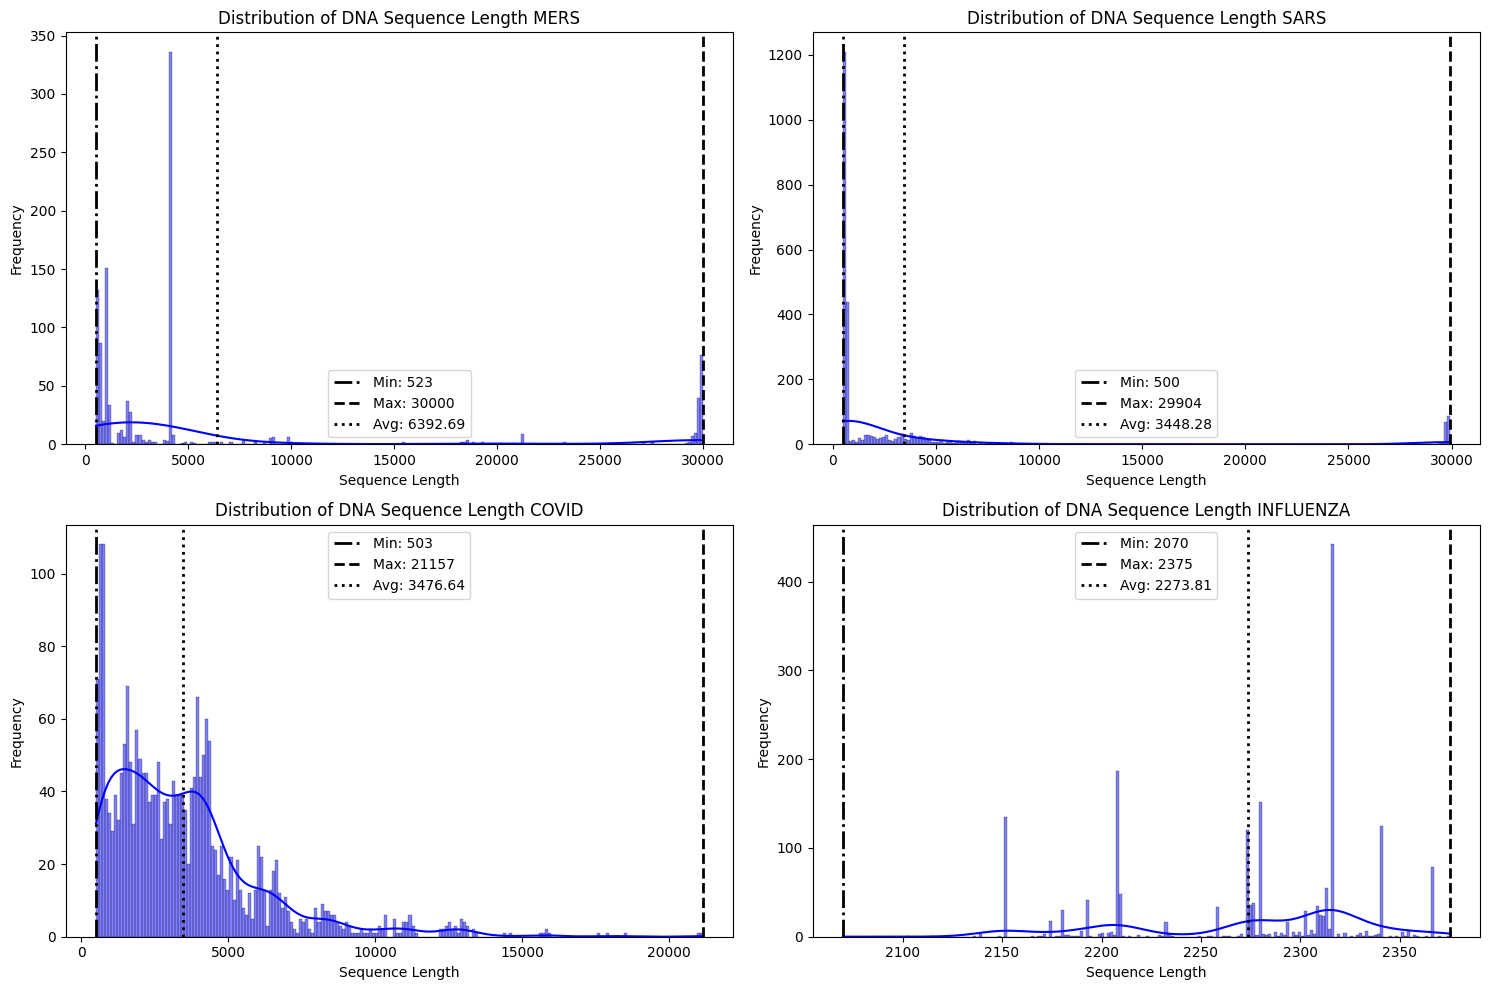

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
mapName = {0: 'MERS', 1: 'SARS', 2: 'COVID', 3: 'INFLUENZA'}

# Flatten axes thành một mảng 1D để dễ truy cập
axes = axes.flatten()

# Duyệt qua các tập dữ liệu và vẽ biểu đồ phân phối độ dài của chuỗi
for i, (dataset, ax) in enumerate(zip([mers_data, sars_data, covid_data, influenza_data], axes)):
    # Tính toán độ dài trung bình, tối thiểu và tối đa của chuỗi
    avg_length = dataset['length'].mean()
    max_length = dataset['length'].max()
    min_length = dataset['length'].min()
    
    # Vẽ biểu đồ phân phối độ dài chuỗi
    sns.histplot(dataset['length'], kde=True, color='blue', bins=200, ax=ax)
    ax.axvline(min_length, color='black', linestyle='dashdot', linewidth=2, label=f'Min: {min_length}')
    ax.axvline(max_length, color='black', linestyle='dashed', linewidth=2, label=f'Max: {max_length}')
    ax.axvline(avg_length, color='black', linestyle='dotted', linewidth=2, label=f'Avg: {avg_length:.2f}')
    ax.set_title(f'Distribution of DNA Sequence Length {mapName[i]}')
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Frequency')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [14]:
def translate_codon(codon):
    # Bảng mã hóa từ codon sang axit amin
#     codon_table = {
#         'TTT': 'Phenylalanine', 'TTC': 'Phenylalanine', 'TTA': 'Leucine', 'TTG': 'Leucine',
#         'TCT': 'Serine', 'TCC': 'Serine', 'TCA': 'Serine', 'TCG': 'Serine',
#         'TAT': 'Tyrosine', 'TAC': 'Tyrosine', 'TAA': 'Stop', 'TAG': 'Stop',
#         'TGT': 'Cysteine', 'TGC': 'Cysteine', 'TGA': 'Stop', 'TGG': 'Tryptophan',
#         'CTT': 'Leucine', 'CTC': 'Leucine', 'CTA': 'Leucine', 'CTG': 'Leucine',
#         'CCT': 'Proline', 'CCC': 'Proline', 'CCA': 'Proline', 'CCG': 'Proline',
#         'CAT': 'Histidine', 'CAC': 'Histidine', 'CAA': 'Glutamine', 'CAG': 'Glutamine',
#         'CGT': 'Arginine', 'CGC': 'Arginine', 'CGA': 'Arginine', 'CGG': 'Arginine',
#         'ATT': 'Isoleucine', 'ATC': 'Isoleucine', 'ATA': 'Isoleucine', 'ATG': 'Methionine',
#         'ACT': 'Threonine', 'ACC': 'Threonine', 'ACA': 'Threonine', 'ACG': 'Threonine',
#         'AAT': 'Asparagine', 'AAC': 'Asparagine', 'AAA': 'Lysine', 'AAG': 'Lysine',
#         'AGT': 'Serine', 'AGC': 'Serine', 'AGA': 'Arginine', 'AGG': 'Arginine',
#         'GTT': 'Valine', 'GTC': 'Valine', 'GTA': 'Valine', 'GTG': 'Valine',
#         'GCT': 'Alanine', 'GCC': 'Alanine', 'GCA': 'Alanine', 'GCG': 'Alanine',
#         'GAT': 'Aspartic Acid', 'GAC': 'Aspartic Acid', 'GAA': 'Glutamic Acid', 'GAG': 'Glutamic Acid',
#         'GGT': 'Glycine', 'GGC': 'Glycine', 'GGA': 'Glycine', 'GGG': 'Glycine'
#     }

    codon_table = {
        '111': 'Phenylalanine', '112': 'Phenylalanine', '113': 'Leucine', '114': 'Leucine',
        '121': 'Serine', '122': 'Serine', '123': 'Serine', '124': 'Serine',
        '131': 'Tyrosine', '132': 'Tyrosine', '133': 'Stop', '134': 'Stop',
        '141': 'Cysteine', '142': 'Cysteine', '143': 'Stop', '144': 'Tryptophan',
        '211': 'Leucine', '212': 'Leucine', '213': 'Leucine', '214': 'Leucine',
        '221': 'Proline', '222': 'Proline', '223': 'Proline', '224': 'Proline',
        '231': 'Histidine', '232': 'Histidine', '233': 'Glutamine', '234': 'Glutamine',
        '241': 'Arginine', '242': 'Arginine', '243': 'Arginine', '244': 'Arginine',
        '311': 'Isoleucine', '312': 'Isoleucine', '313': 'Isoleucine', '314': 'Methionine',
        '321': 'Threonine', '322': 'Threonine', '323': 'Threonine', '324': 'Threonine',
        '331': 'Asparagine', '332': 'Asparagine', '333': 'Lysine', '334': 'Lysine',
        '341': 'Serine', '342': 'Serine', '343': 'Arginine', '344': 'Arginine',
        '411': 'Valine', '412': 'Valine', '413': 'Valine', '414': 'Valine',
        '421': 'Alanine', '422': 'Alanine', '423': 'Alanine', '424': 'Alanine',
        '431': 'Aspartic Acid', '432': 'Aspartic Acid', '433': 'Glutamic Acid', '434': 'Glutamic Acid',
        '441': 'Glycine', '442': 'Glycine', '443': 'Glycine', '444': 'Glycine'
    }
    
    # Kiểm tra xem codon có trong bảng mã hóa không
    if codon in codon_table:
        return codon_table[codon]
    else:
        return 'Unknown'

In [15]:
def translate_dna_sequences(dna_sequences):
    axitamin_list = []
    
    for dna_sequence in dna_sequences:
        for i in range(0, len(dna_sequence) - 3, 3):
            da = [str(x) for x in dna_sequence[i:i+3]]
            codon = ''.join(da)
            amino_acid = translate_codon(codon)
            if amino_acid != 'Stop':
                axitamin_list.append(amino_acid)
            else:
                break  
    return axitamin_list

In [16]:
axitamin_covid = translate_dna_sequences(covid_encoding)
axitamin_mers = translate_dna_sequences(mers_encoding)
axitamin_sars = translate_dna_sequences(sars_encoding)
axitamin_influenza = translate_dna_sequences(influenza_encoding)

In [17]:
axitamin_covid_data = pd.DataFrame({'axitamin': axitamin_covid})
axitamin_mers_data = pd.DataFrame({'axitamin': axitamin_mers})
axitamin_sars_data = pd.DataFrame({'axitamin': axitamin_sars})
axitamin_influenza_data = pd.DataFrame({'axitamin': axitamin_influenza})

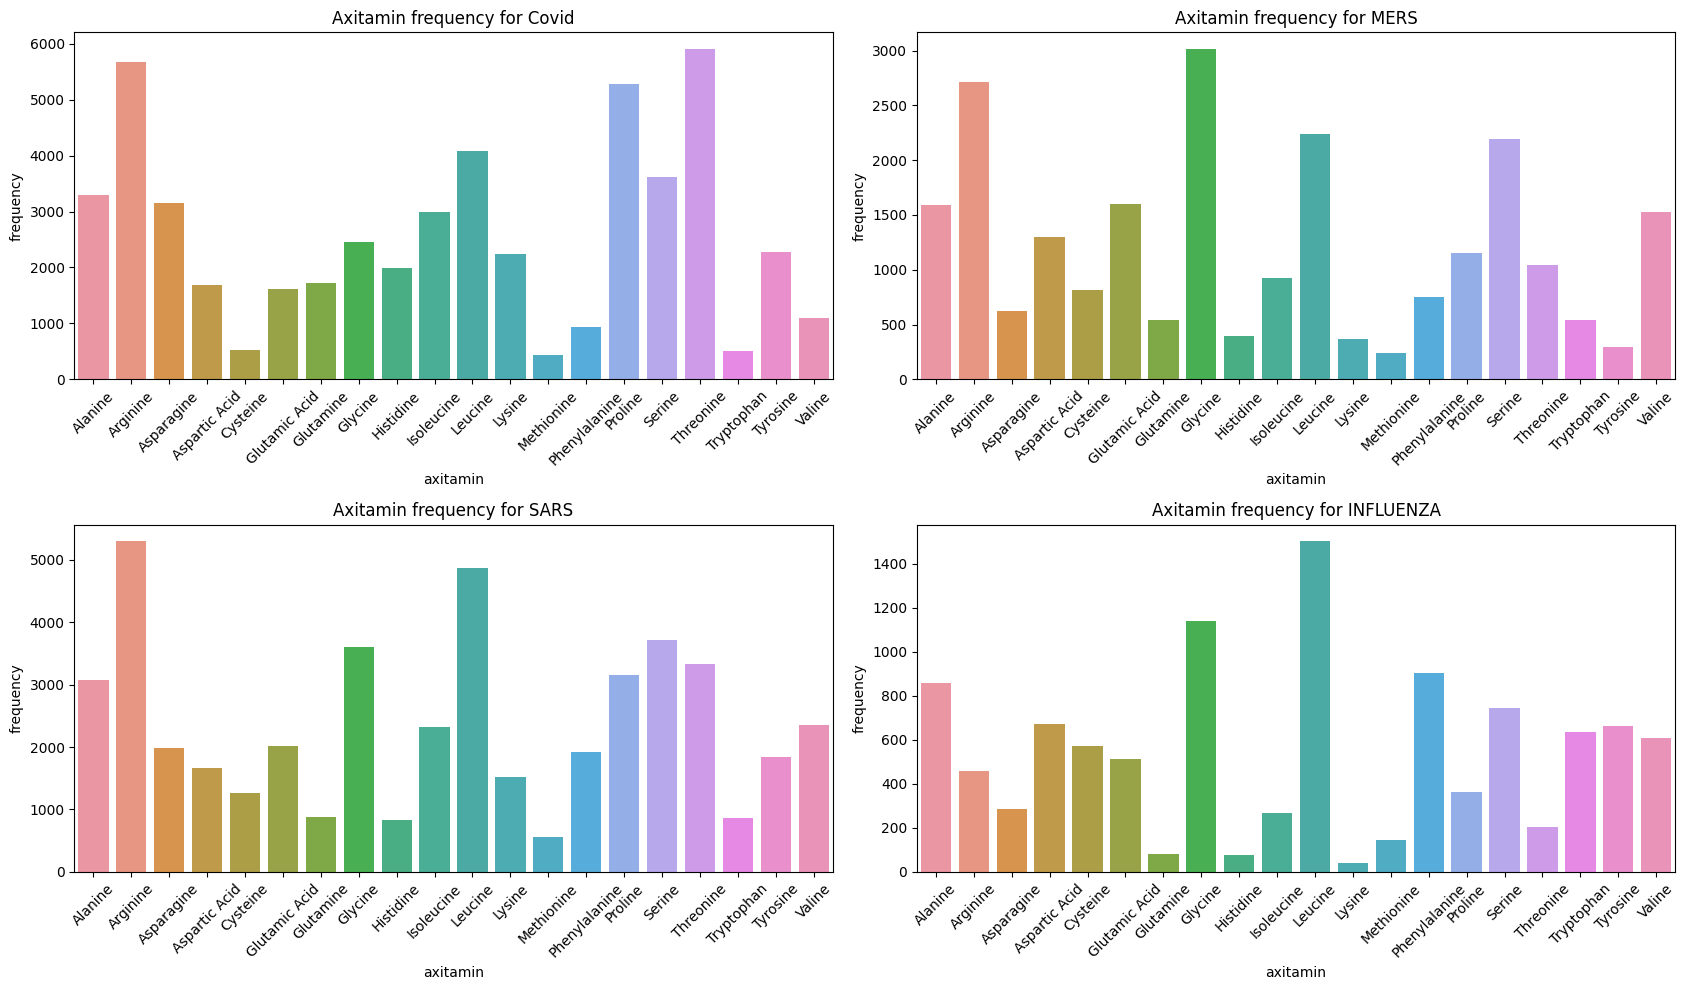

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

# Flatten axes thành một mảng 1D để dễ truy cập
axes = axes.flatten()

# Vẽ biểu đồ cho train_data
sorted_data = axitamin_covid_data['axitamin'].value_counts().sort_index()
plt.sca(axes[0])
plt.xticks(rotation=45)
plt.xlabel('axit amin')
sns.countplot(data=axitamin_covid_data, x='axitamin', order=sorted_data.index)
plt.title('Axitamin frequency for Covid')
plt.ylabel('frequency')

# Vẽ biểu đồ cho train_data1
sorted_data = axitamin_mers_data['axitamin'].value_counts().sort_index()
plt.sca(axes[1])
plt.xticks(rotation=45)
plt.xlabel('axit amin')
sns.countplot(data=axitamin_mers_data, x='axitamin', order=sorted_data.index)
plt.title('Axitamin frequency for MERS')
plt.ylabel('frequency')

# Vẽ biểu đồ cho train_data2
sorted_data = axitamin_sars_data['axitamin'].value_counts().sort_index()
plt.sca(axes[2])
plt.xticks(rotation=45)
plt.xlabel('axit amin')
sns.countplot(data=axitamin_sars_data, x='axitamin', order=sorted_data.index)
plt.title('Axitamin frequency for SARS')
plt.ylabel('frequency')

# Vẽ biểu đồ cho train_data3
sorted_data = axitamin_influenza_data['axitamin'].value_counts().sort_index()
plt.sca(axes[3])
plt.xticks(rotation=45)
plt.xlabel('axit amin')
sns.countplot(data=axitamin_influenza_data, x='axitamin', order = sorted_data.index)
plt.title('Axitamin frequency for INFLUENZA')

plt.ylabel('frequency')
plt.tight_layout()
plt.show()

In [16]:
#
# Labeling data
#
mers_label = [0] * len(mers_encoding)
sars_label = [1] * len(sars_encoding)
covid_label = [2] * len(covid_encoding)
influenza_label = [3] * len(influenza_encoding)
# dengue_label = [3] * len(dengue_encoding)
# hepatitis_label = [4] * len(hepatitis_encoding)

In [17]:
#
# Create data with DataFrame format
#
train_data = pd.DataFrame({'dna': mers_encoding + sars_encoding + covid_encoding + influenza_encoding, 'label': mers_label + sars_label + covid_label + influenza_label})
train_data.head()

,dna,label
0,"[2, 3, 4, 4, 2, 4, 2, 4, 4, 3, 2, 1, 3, 1, 1, ...",0
1,"[1, 4, 4, 4, 3, 2, 2, 4, 3, 2, 4, 2, 1, 4, 2, ...",0
2,"[3, 4, 4, 2, 4, 2, 4, 4, 3, 2, 1, 3, 1, 1, 2, ...",0
3,"[3, 4, 4, 2, 4, 2, 4, 4, 3, 2, 1, 3, 1, 1, 2, ...",0
4,"[3, 4, 4, 2, 4, 2, 4, 4, 3, 2, 1, 3, 1, 1, 2, ...",0


In [10]:
train_data = train_data.drop_duplicates(subset=['dna'])
train_data.head()

,dna,label
0,"[2, 3, 4, 4, 2, 4, 2, 4, 4, 3, 2, 1, 3, 1, 1, ...",0
1,"[1, 4, 4, 4, 3, 2, 2, 4, 3, 2, 4, 2, 1, 4, 2, ...",0
2,"[3, 4, 4, 2, 4, 2, 4, 4, 3, 2, 1, 3, 1, 1, 2, ...",0
5,"[3, 4, 4, 2, 4, 2, 4, 4, 3, 2, 1, 3, 1, 1, 2, ...",0
6,"[3, 4, 4, 2, 4, 2, 4, 4, 3, 2, 1, 3, 1, 1, 2, ...",0


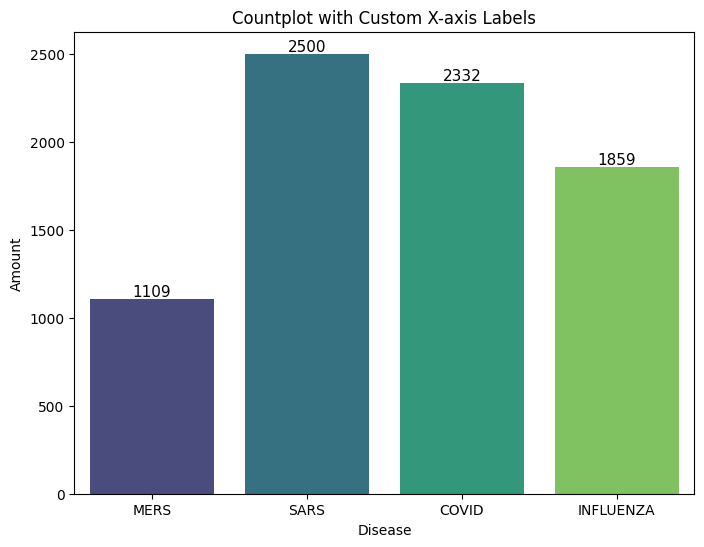

In [18]:
#
# Statistic label for each disease
#

custom_labels = {0: 'MERS', 1: 'SARS', 2: 'COVID', 3: 'INFLUENZA'}

# Create a countplot with custom x-axis labels
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data,x='label', palette='viridis')
plt.xticks(ticks=sorted(custom_labels.keys()), labels=[custom_labels[i] for i in sorted(custom_labels.keys())])
plt.xlabel('Disease')
plt.ylabel('Amount')
plt.title('Countplot with Custom X-axis Labels')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

In [22]:
#
# get max_length to padding sequence 
# Note that: Devide 2 because devices are not enough :v bruh
#
# max_length = int(max([len(x) for x in train_data['dna']]) / 3)
max_length = 1000
max_length

1000

# Create model

In [57]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.build((7800,1000))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (7800, 1000, 8)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (7800, 998, 128)       │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (7800, 499, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (7800, 497, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (7800, 248, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (7800, 15872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (7800, 128)            │     2,031,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (7800, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (7800, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (7800, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (7800, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,076,100 (7.92 MB)

 Trainable params: 2,076,100 (7.92 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.01)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.LSTM(units = 512))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

nerual_model = keras.Sequential()
nerual_model.add(layers.Dense(units=256, activation='relu'))
nerual_model.add(layers.Dropout(rate=0.2))
nerual_model.add(layers.Dense(units=128, activation='relu'))
nerual_model.add(layers.Dropout(rate=0.2))
nerual_model.add(layers.Dense(units=4, activation='softmax'))
nerual_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

nerual_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train model

In [46]:
data_padding = pad_sequences(train_data['dna'], maxlen=max_length,value=0,padding='post')

In [47]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)

In [48]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(data_padding, y_tf, test_size = 0.2, random_state=42)

In [58]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(dna_train ,label_train, batch_size=32, epochs=8)

Epoch 1/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6193 - loss: 0.8721
Epoch 2/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8679 - loss: 0.3362
Epoch 3/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9135 - loss: 0.2147
Epoch 4/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9356 - loss: 0.1576
Epoch 5/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9521 - loss: 0.1162
Epoch 6/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9549 - loss: 0.1035
Epoch 7/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9572 - loss: 0.0992
Epoch 8/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9573 - loss: 0.0962


# SVM

In [28]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(data_padding, train_data['label'], test_size = 0.2, random_state=42)

In [29]:
from sklearn.svm import SVC

model = SVC(kernel = 'rbf', random_state = 41)
model.fit(dna_train, label_train)

SVC(random_state=41)

In [30]:
test_prediction = model.predict(dna_test)
test_prediction

array([1, 2, 1, ..., 1, 2, 2])

In [31]:
print(classification_report(test_prediction, label_test))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       194
           1       0.83      0.92      0.87       454
           2       0.97      0.77      0.86       572
           3       0.94      1.00      0.97       340

    accuracy                           0.89      1560
   macro avg       0.89      0.92      0.90      1560
weighted avg       0.90      0.89      0.89      1560



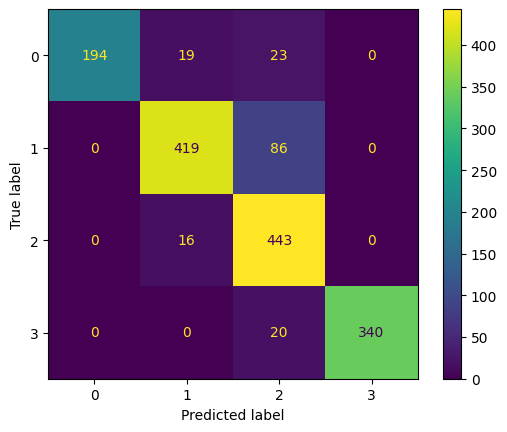

In [33]:
cm = confusion_matrix(label_test, test_prediction, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [26]:
mers_data_test = read_data('/kaggle/input/dna-sequence-testing/SARS_TEST.fasta')
mers_data_encoding = data_preprocessing(mers_data_test)

In [ ]:
covid_data_test = read_data('/kaggle/input/dna-sequence-testing/COVID_TEST.fasta')
covid_data_encoding = data_preprocessing(covid_data_test)

In [27]:
p = pad_sequences(mers_data_encoding, maxlen=max_length,value=0,padding='post')

In [29]:
results = model.predict(p)
results[:3]

array([1, 1, 1])

In [ ]:
results = np.argmax(results, axis = 1)
results[:3]

In [31]:
print('accuracy:' ,round(list(results).count(1) / len(list(results)), 2))

accuracy: 0.99


# Test model

In [59]:
test_prediction = model.predict(dna_test)
test_prediction[0]

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


array([2.8842085e-04, 9.9935824e-01, 3.5258010e-04, 7.0605716e-07],
      dtype=float32)

In [60]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [61]:
print(classification_report(test_pre, test_label))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       243
           1       0.85      0.92      0.88       466
           2       0.93      0.86      0.89       498
           3       0.98      1.00      0.99       353

    accuracy                           0.92      1560
   macro avg       0.93      0.93      0.93      1560
weighted avg       0.92      0.92      0.92      1560



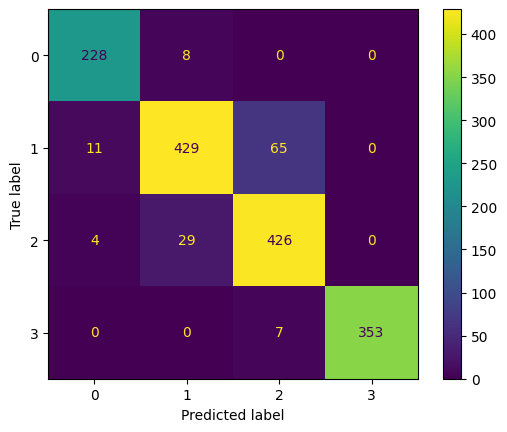

In [62]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [19]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [20]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

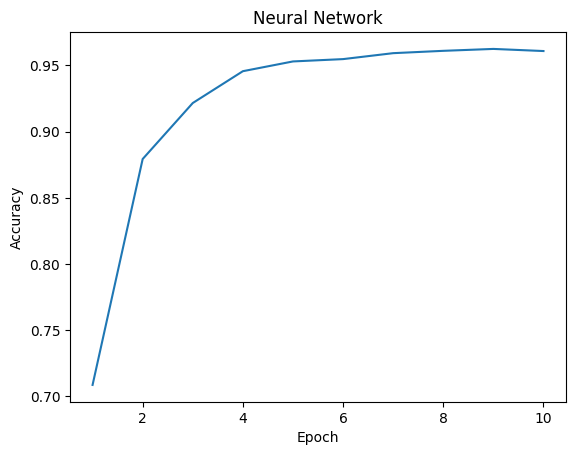

In [21]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.title('Neural Network')
# for i, (xi, yi) in enumerate(zip(epoch, accuracy_his)):
#     plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
plt.show()

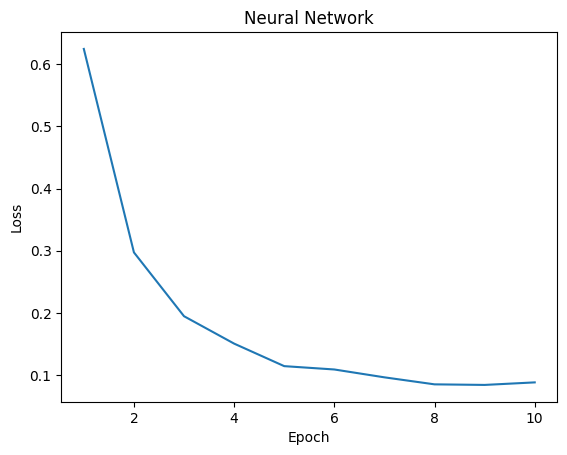

In [44]:
#
# Display loss history
#
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
plt.title('Neural Network')
# for i, (xi, yi) in enumerate(zip(epoch, loss_his)):
#     plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
plt.show()

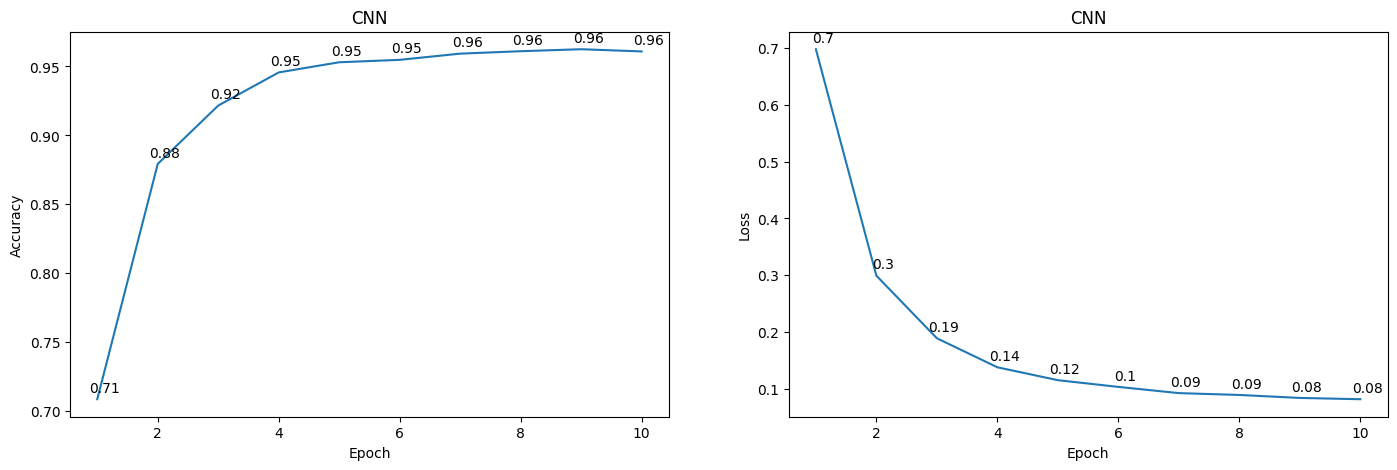

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

axes = axes.flatten()

plt.sca(axes[0])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.title('CNN')
for i, (xi, yi) in enumerate(zip(epoch, accuracy_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
    
plt.sca(axes[1])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
plt.title('CNN')
for i, (xi, yi) in enumerate(zip(epoch, loss_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')

plt.show()

# Protein Sequence Classification

# Data Preprocessing

In [100]:
#
# Change from sequence to int[], using mapping dict
#
amino_acid_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}
def data_preprocessing(data):
    results = []
    for row in data:
        check = False
        arr = []
        for i in range(len(row)):
            if(row[i] not in amino_acid_dict.keys()):
                check = True
                break
            arr.append(amino_acid_dict[row[i]])
        if(check == False and 100 <= len(arr) <= 5000):
            results.append(arr)
    return results

In [103]:
#
# Read data
#
protein_mers_data = read_data('/kaggle/input/protein-sequence/MERS2.fasta')
protein_sars_data = read_data('/kaggle/input/protein-sequence/SARS_PROTEIN.fasta')
protein_covid_data = read_data('/kaggle/input/protein-sequence/COVID_PROTEIN.fasta')
protein_influenza_data = read_data('/kaggle/input/protein-sequence/DENGUE_PROTEIN.fasta')

In [104]:
#
# Encode data
#
protein_mers_encoding = data_preprocessing(protein_mers_data)
protein_sars_encoding = data_preprocessing(protein_sars_data)
protein_covid_encoding = data_preprocessing(protein_covid_data)
# protein_dengue_encoding = data_preprocessing(protein_dengue_data)
protein_influenza_encoding = data_preprocessing(protein_influenza_data)
# protein_hepatitis_encoding = data_preprocessing(protein_hepatitis_data)

In [105]:
#
# Create label for each disease
#
protein_mers_label = [0] * len(protein_mers_encoding)
protein_sars_label = [1] * len(protein_sars_encoding)
protein_covid_label = [2] * len(protein_covid_encoding)
protein_influenza_label = [3] * len(protein_influenza_encoding)
# protein_dengue_label = [3] * len(protein_dengue_encoding)
# protein_hepatitis_label = [5] * len(protein_hepatitis_encoding)

In [67]:
protein_mers_data = pd.DataFrame({'protein': protein_mers_encoding})
protein_sars_data = pd.DataFrame({'protein': protein_sars_encoding})
protein_covid_data = pd.DataFrame({'protein': protein_covid_encoding})
protein_influenza_data = pd.DataFrame({'protein': protein_influenza_encoding})

In [19]:
protein_mers_data['length'] = protein_mers_data['protein'].apply(lambda x: len(x))
protein_sars_data['length'] = protein_sars_data['protein'].apply(lambda x: len(x))
protein_covid_data['length'] = protein_covid_data['protein'].apply(lambda x: len(x))
protein_influenza_data['length'] = protein_influenza_data['protein'].apply(lambda x: len(x))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

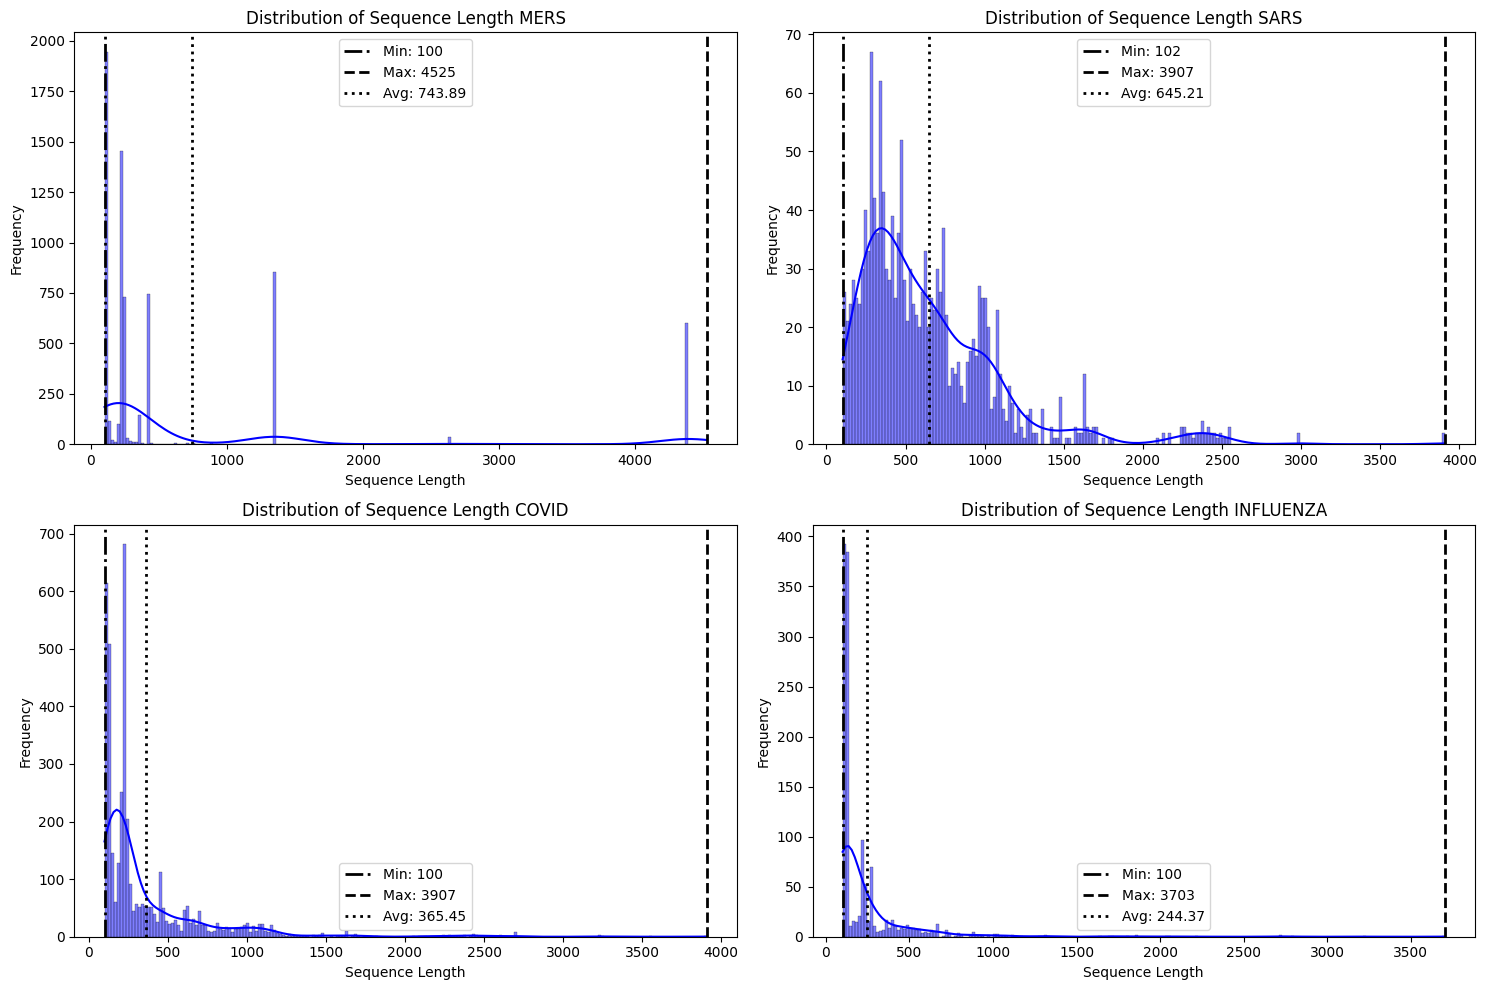

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
mapName = {0: 'MERS', 1: 'SARS', 2: 'COVID', 3: 'INFLUENZA'}

# Flatten axes thành một mảng 1D để dễ truy cập
axes = axes.flatten()

# Duyệt qua các tập dữ liệu và vẽ biểu đồ phân phối độ dài của chuỗi
for i, (dataset, ax) in enumerate(zip([protein_mers_data, protein_sars_data, protein_covid_data, protein_influenza_data], axes)):
    # Tính toán độ dài trung bình, tối thiểu và tối đa của chuỗi
    avg_length = dataset['length'].mean()
    max_length = dataset['length'].max()
    min_length = dataset['length'].min()
    
    # Vẽ biểu đồ phân phối độ dài chuỗi
    sns.histplot(dataset['length'], kde=True, color='blue', bins=200, ax=ax)
    ax.axvline(min_length, color='black', linestyle='dashdot', linewidth=2, label=f'Min: {min_length}')
    ax.axvline(max_length, color='black', linestyle='dashed', linewidth=2, label=f'Max: {max_length}')
    ax.axvline(avg_length, color='black', linestyle='dotted', linewidth=2, label=f'Avg: {avg_length:.2f}')
    ax.set_title(f'Distribution of Sequence Length {mapName[i]}')
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Frequency')
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

In [106]:
#
# Create data in form of 'DataFrame'
#
protein_train_data = pd.DataFrame({'protein': protein_mers_encoding + protein_sars_encoding + protein_covid_encoding + protein_influenza_encoding ,
                           'label': protein_mers_label + protein_sars_label + protein_covid_label + protein_influenza_label})
protein_train_data.head()

,protein,label
0,"[13, 16, 3, 13, 17, 6, 11, 17, 7, 1, 6, 10, 10...",0
1,"[13, 1, 14, 16, 1, 16, 11, 14, 12, 15, 20, 6, ...",0
2,"[13, 7, 7, 16, 11, 17, 4, 20, 15, 16, 17, 16, ...",0
3,"[13, 4, 19, 20, 16, 11, 11, 3, 6, 10, 18, 6, 1...",0
4,"[13, 2, 20, 6, 2, 15, 15, 17, 11, 11, 11, 20, ...",0


In [107]:
#
# Drop duplicate sequences
#
protein_train_data.drop_duplicates(subset=['protein'], inplace=True)
protein_train_data.head()

,protein,label
0,"[13, 16, 3, 13, 17, 6, 11, 17, 7, 1, 6, 10, 10...",0
1,"[13, 1, 14, 16, 1, 16, 11, 14, 12, 15, 20, 6, ...",0
2,"[13, 7, 7, 16, 11, 17, 4, 20, 15, 16, 17, 16, ...",0
3,"[13, 4, 19, 20, 16, 11, 11, 3, 6, 10, 18, 6, 1...",0
4,"[13, 2, 20, 6, 2, 15, 15, 17, 11, 11, 11, 20, ...",0


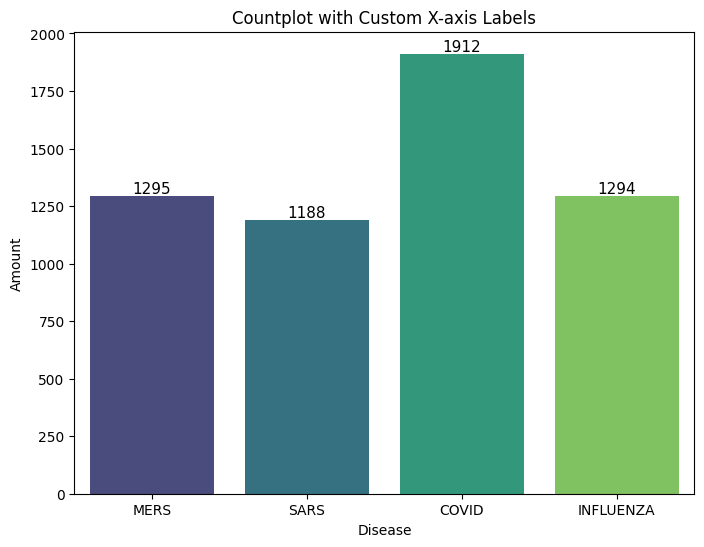

In [108]:
#
# Statistic label for each disease
#

custom_labels = {0: 'MERS', 1: 'SARS', 2: 'COVID', 3: 'INFLUENZA'}

# Create a countplot with custom x-axis labels
plt.figure(figsize=(8, 6))
sns.countplot(data=protein_train_data,x='label', palette='viridis')
plt.xticks(ticks=sorted(custom_labels.keys()), labels=[custom_labels[i] for i in sorted(custom_labels.keys())])
plt.xlabel('Disease')
plt.ylabel('Amount')
plt.title('Countplot with Custom X-axis Labels')

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

<Axes: xlabel='label', ylabel='count'>

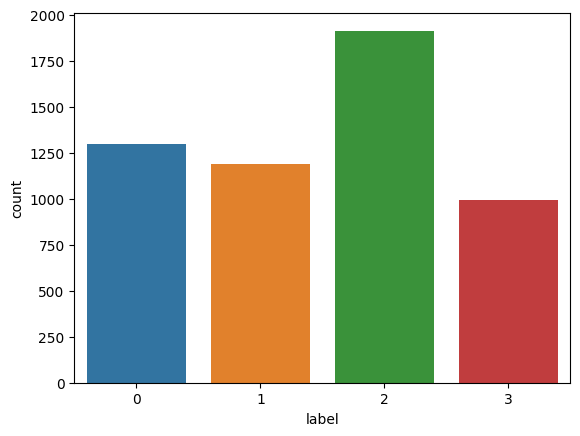

In [11]:
#
# Statistic per label
#
sns.countplot(data=protein_train_data, x = 'label')

In [71]:
#
# Get max_length to pad sequence
#
# protein_max_length = int(max([len(x) for x in protein_train_data['protein']]))
protein_max_length = 2000
protein_max_length

2000

# Create model

In [72]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

neural_model = keras.Sequential()
neural_model.add(tf.keras.layers.Embedding(input_dim=protein_max_length,output_dim=8))
neural_model.add(layers.Flatten())
neural_model.add(layers.Dense(units=256, activation='relu'))
neural_model.add(layers.Dropout(rate=0.2))
neural_model.add(layers.Dense(units=128, activation='relu'))
neural_model.add(layers.Dropout(rate=0.2))
neural_model.add(layers.Dense(units=4, activation='softmax'))
neural_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

neural_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [109]:
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=protein_max_length,output_dim=8))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train model

In [110]:
#
# Padding sequences
#
protein_data_padding = pad_sequences(protein_train_data['protein'], maxlen=protein_max_length,value=0,padding='post')

In [111]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(protein_train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)
y_tf 

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [112]:
#
# Splitting data
#
protein_train, protein_test, label_train, label_test = train_test_split(protein_data_padding, y_tf, test_size = 0.2, random_state=42)

In [113]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(protein_train ,label_train, batch_size=32, epochs=9)

Epoch 1/9
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5969 - loss: 0.9485
Epoch 2/9
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8508 - loss: 0.3552
Epoch 3/9
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8985 - loss: 0.2333
Epoch 4/9
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9489 - loss: 0.1329
Epoch 5/9
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9692 - loss: 0.0793
Epoch 6/9
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9914 - loss: 0.0416
Epoch 7/9
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9914 - loss: 0.0242
Epoch 8/9
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9923 - loss: 0.0262
Epoch 9/9
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9981 - loss: 0.0101


In [118]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(protein_data_padding, protein_train_data['label'], test_size = 0.2, random_state=42)

In [119]:
from sklearn.svm import SVC

model = SVC(kernel = 'rbf', random_state = 41)
model.fit(dna_train, label_train)

SVC(random_state=41)

In [120]:
test_prediction = model.predict(dna_test)
test_prediction

array([2, 3, 3, ..., 2, 0, 0])

In [121]:
print(classification_report(test_prediction, label_test))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       230
           1       0.80      0.65      0.72       287
           2       0.79      0.73      0.76       382
           3       0.88      1.00      0.93       239

    accuracy                           0.82      1138
   macro avg       0.82      0.84      0.82      1138
weighted avg       0.81      0.82      0.81      1138



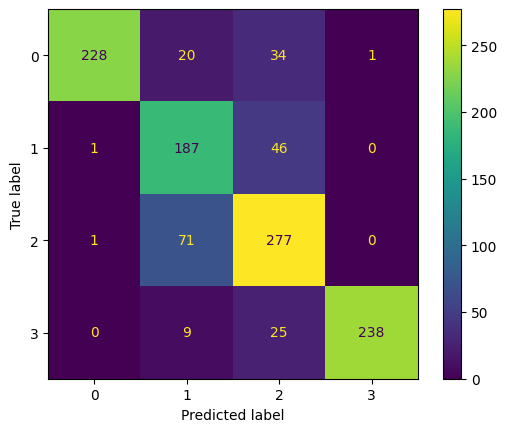

In [122]:
cm = confusion_matrix(label_test, test_prediction, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

# Test model

In [114]:
test_prediction = model.predict(protein_test)
test_prediction[0]

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


array([9.987096e-12, 1.675781e-11, 1.000000e+00, 4.134309e-13],
      dtype=float32)

In [115]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [116]:
print(classification_report(test_pre, test_label))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       297
           1       0.79      0.81      0.80       227
           2       0.86      0.88      0.87       344
           3       0.99      1.00      0.99       270

    accuracy                           0.90      1138
   macro avg       0.90      0.90      0.90      1138
weighted avg       0.90      0.90      0.90      1138



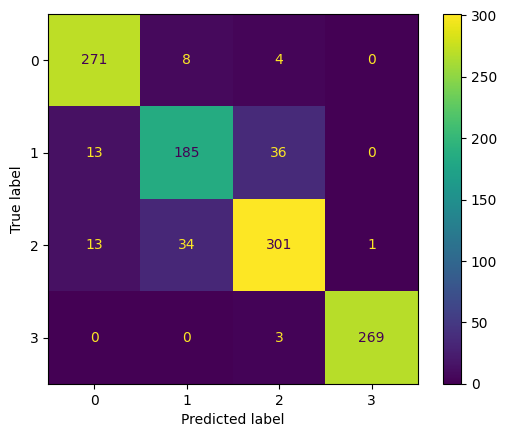

In [117]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [51]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [52]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

[1, 2, 3, 4, 5, 6, 7]

In [ ]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
for i, (xi, yi) in enumerate(zip(epoch, accuracy_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
plt.show()

#
# Display loss history
#
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his, color = 'red')
for i, (xi, yi) in enumerate(zip(epoch, loss_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
plt.show()

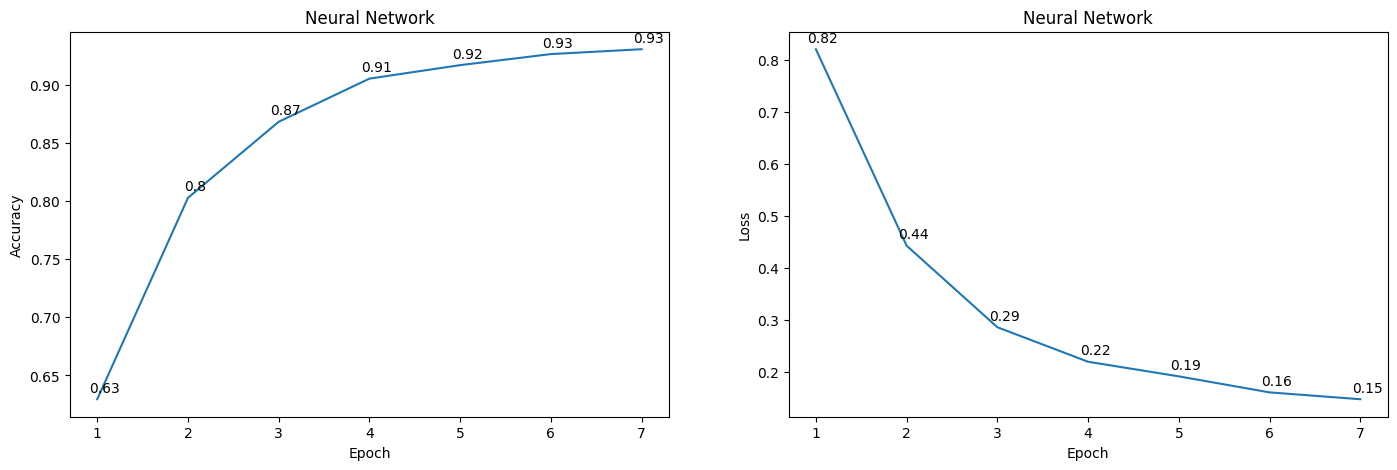

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

axes = axes.flatten()

plt.sca(axes[0])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.title('Neural Network')
for i, (xi, yi) in enumerate(zip(epoch, accuracy_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
    
plt.sca(axes[1])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
plt.title('Neural Network')
for i, (xi, yi) in enumerate(zip(epoch, loss_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')

plt.show()

# **K-mer Encoding**

# DNA Sequence Classification

# *Preprocessing data*

In [55]:
k_mer = 10
def k_merEncoding(data):
    data = data_preprocessing(data)
    max_length = 1000
    dataPadding = pad_sequences(data, maxlen=max_length,value=0,padding='post')
    dataPadding = list(dataPadding)
    for i in range(len(dataPadding)):
        k_merEncode = [dataPadding[i][j:j+k_mer] for j in range(0, len(dataPadding[i]) - k_mer)]
        dataPadding[i] = k_merEncode
    return dataPadding

In [ ]:
#
# K-mer Encoding data
#
mers_k_mer_encoding = k_merEncoding(mers_data)
sars_k_mer_encoding = k_merEncoding(sars_data[:3000])
covid_k_mer_encoding = k_merEncoding(covid_data)
influenza_k_mer_encoding = k_merEncoding(influenza_data)

In [59]:
#
# Labeling data
#
mers_label = [0] * len(mers_k_mer_encoding)
sars_label = [1] * len(sars_k_mer_encoding)
covid_label = [2] * len(covid_k_mer_encoding)
influenza_label = [3] * len(influenza_k_mer_encoding)

In [72]:
#
# Create data with DataFrame format
#
train_data = pd.DataFrame({'dna': mers_k_mer_encoding + sars_k_mer_encoding + covid_k_mer_encoding + influenza_k_mer_encoding, 'label': mers_label + sars_label + covid_label +influenza_label})
train_data.head()

,dna,label
0,"[[8, 8, 17, 17, 5, 1, 8, 8, 1, 17], [8, 17, 17...",0
1,"[[8, 8, 17, 17, 5, 1, 8, 8, 1, 17], [8, 17, 17...",0
2,"[[8, 8, 17, 17, 5, 1, 8, 8, 1, 17], [8, 17, 17...",0
3,"[[8, 8, 17, 17, 5, 1, 8, 8, 1, 17], [8, 17, 17...",0
4,"[[8, 8, 17, 17, 5, 1, 8, 8, 1, 17], [8, 17, 17...",0


In [62]:
#
# get max_length to padding sequence 
# Note that: Devide 2 because devices are not enough :v bruh
#
# max_length = int(max([len(x) for x in train_data['dna']]) / 3)
max_length = 1000
max_length

1000

# *Create modal*

In [93]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(990, 10, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 988, 8, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 494, 4, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 492, 2, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 246, 1, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 15744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │     2,015,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,098,948 (8.01 MB)

 Trainable params: 2,098,948 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

neural_model = keras.Sequential()
# neural_model.add(tf.keras.layers.Embedding(input_dim=protein_max_length,output_dim=8))
# neural_model.add(layers.Flatten())
neural_model.add(layers.Dense(units=256,input_shape=(990,10),activation='relu'))
neural_model.add(layers.Dropout(rate=0.2))
neural_model.add(layers.Dense(units=128, activation='relu'))
neural_model.add(layers.Dropout(rate=0.2))
neural_model.add(layers.Dense(units=4, activation='softmax'))
neural_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

neural_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 990, 256)       │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 990, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 990, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 990, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 990, 4)         │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,228 (141.52 KB)

 Trainable params: 36,228 (141.52 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:

# A simpleRNN without any pretrained embeddings and one dense layer
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.005, use_ema=True)

cnn_lstm_model = keras.Sequential()
# cnn_lstm_model.add(TimeDistributed(Embedding(input_dim=max_length,output_dim=8)))
# cnn_lstm_model.add(layers.Input(shape=(32,990, 10, 1), batch_size=32))
cnn_lstm_model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(1,10), activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
cnn_lstm_model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(1,10), activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
cnn_lstm_model.add(TimeDistributed(Flatten()))

cnn_lstm_model.add(layers.LSTM(units=128, activation='tanh', unit_forget_bias=False))

cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(Dense(units=128, activation='relu'))
cnn_lstm_model.add(Dense(units=4, activation='softmax'))

cnn_lstm_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

cnn_lstm_model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_15             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# *Train model*

In [87]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)

In [88]:
#
# Convert list to numpy array
#
data = np.array([np.array(x) for x in train_data['dna']])

In [90]:
#
# Splitting data
#
dna_train, dna_test, label_train, label_test = train_test_split(data, y_tf, test_size = 0.2, random_state=42)

In [91]:
ex_dna_train = np.expand_dims(dna_train, axis = -1)
ex_dna_train.shape

(7065, 990, 10, 1)

In [ ]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = cnn_lstm_model.fit(ex_dna_train ,label_train, batch_size=32, epochs=7)

# *Test model*

In [ ]:
test_prediction = model.predict(dna_test)
test_prediction[0]

In [96]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [97]:
print(classification_report(test_pre, test_label))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       269
           1       0.97      0.91      0.94       579
           2       0.89      0.98      0.94       537
           3       0.99      0.98      0.99       382

    accuracy                           0.95      1767
   macro avg       0.95      0.94      0.94      1767
weighted avg       0.95      0.95      0.95      1767



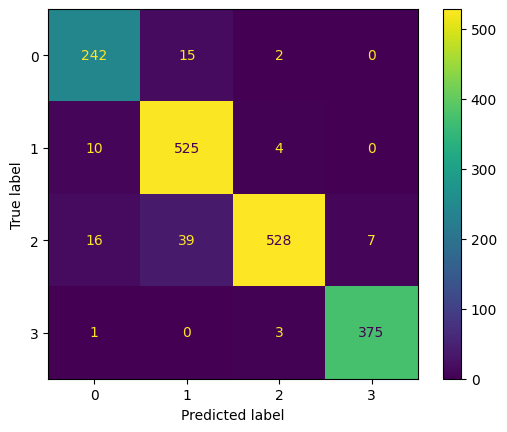

In [98]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

In [99]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

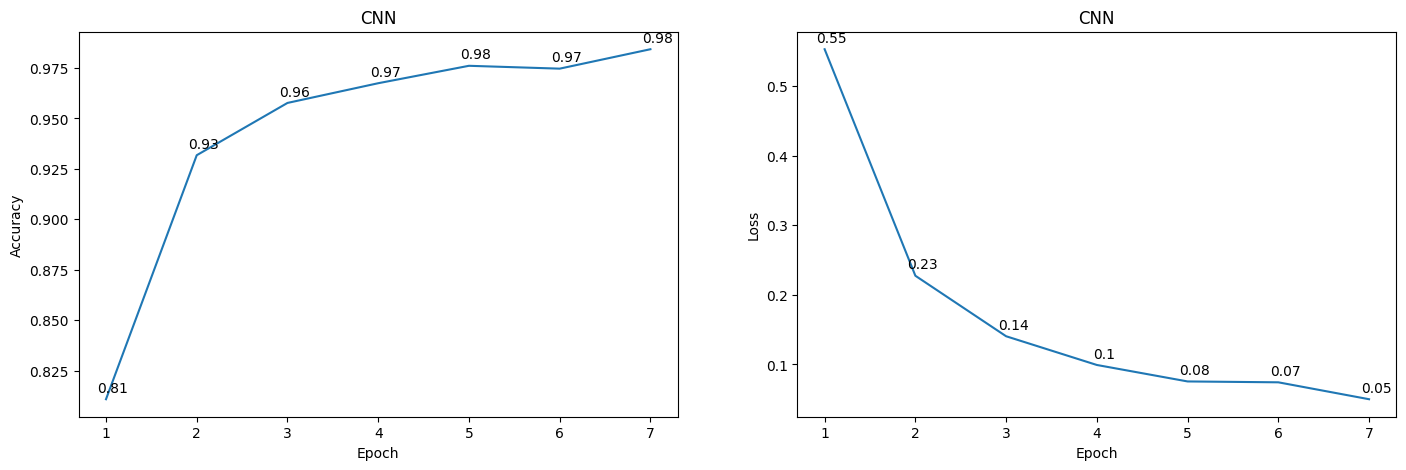

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

axes = axes.flatten()

plt.sca(axes[0])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.title('CNN')
for i, (xi, yi) in enumerate(zip(epoch, accuracy_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
    
plt.sca(axes[1])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
plt.title('CNN')
for i, (xi, yi) in enumerate(zip(epoch, loss_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')

plt.show()

In [ ]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

In [ ]:
#
# Display accuracy history
#
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.show()

In [ ]:
#
# Display loss history
#
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
plt.show()

# **Protein Sequence Classification**

In [167]:
k_mer = 10
def k_merEncoding(data):
    data = data_preprocessing(data)
    max_length = 1000
    dataPadding = pad_sequences(data, maxlen=max_length,value=0,padding='post')
    dataPadding = list(dataPadding)
    for i in range(len(dataPadding)):
        k_merEncode = [dataPadding[i][j:j+k_mer] for j in range(0, len(dataPadding[i]) - k_mer)]
        dataPadding[i] = k_merEncode
    return dataPadding

In [168]:
#
# K-mer Encoding data
#
protein_mers_k_mer_encoding = k_merEncoding(protein_mers_data)
protein_sars_k_mer_encoding = k_merEncoding(protein_sars_data)
protein_covid_k_mer_encoding = k_merEncoding(protein_covid_data)
protein_influenza_k_mer_encoding = k_merEncoding(protein_influenza_data)

In [169]:
#
# Create label for each disease
#
protein_mers_label = [0] * len(protein_mers_k_mer_encoding)
protein_sars_label = [1] * len(protein_sars_k_mer_encoding)
protein_covid_label = [2] * len(protein_covid_k_mer_encoding)
protein_influenza_label = [3] * len(protein_influenza_k_mer_encoding)
# protein_dengue_label = [3] * len(protein_dengue_encoding)
# protein_hepatitis_label = [5] * len(protein_hepatitis_encoding)

In [170]:
#
# Create data in form of 'DataFrame'
#
protein_train_data = pd.DataFrame({'protein': protein_mers_k_mer_encoding + protein_sars_k_mer_encoding + protein_covid_k_mer_encoding + protein_influenza_k_mer_encoding ,
                           'label': protein_mers_label + protein_sars_label + protein_covid_label + protein_influenza_label})
protein_train_data.head()

,protein,label
0,"[[13, 16, 3, 13, 17, 6, 11, 17, 7, 1], [16, 3,...",0
1,"[[13, 1, 14, 16, 1, 16, 11, 14, 12, 15], [1, 1...",0
2,"[[13, 7, 7, 16, 11, 17, 4, 20, 15, 16], [7, 7,...",0
3,"[[13, 4, 19, 20, 16, 11, 11, 3, 6, 10], [4, 19...",0
4,"[[13, 2, 20, 6, 2, 15, 15, 17, 11, 11], [2, 20...",0


In [171]:
#
# Drop duplicate sequences
#
protein_train_data.drop_duplicates(subset=['protein'], inplace=True)
protein_train_data.head()

,protein,label
0,"[[13, 16, 3, 13, 17, 6, 11, 17, 7, 1], [16, 3,...",0
1,"[[13, 1, 14, 16, 1, 16, 11, 14, 12, 15], [1, 1...",0
2,"[[13, 7, 7, 16, 11, 17, 4, 20, 15, 16], [7, 7,...",0
3,"[[13, 4, 19, 20, 16, 11, 11, 3, 6, 10], [4, 19...",0
4,"[[13, 2, 20, 6, 2, 15, 15, 17, 11, 11], [2, 20...",0


In [172]:
#
# Create CNN model with keras
# A simpleRNN without any pretrained embeddings and one dense layer
#
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = keras.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(990, 10, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(units=4, activation='softmax'))
model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 988, 8, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 494, 4, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 492, 2, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 246, 1, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 15744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │     2,015,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,098,948 (8.01 MB)

 Trainable params: 2,098,948 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

In [173]:
#
# One-hot encoding label
#
y_tf = tf.keras.utils.to_categorical(protein_train_data['label'], num_classes = 4)
y_tf = np.array(y_tf, dtype=int)

In [174]:
#
# Convert list to numpy array
#
data = np.array([np.array(x) for x in protein_train_data['protein']])

In [175]:
#
# Splitting data
#
protein_train, protein_test, label_train, label_test = train_test_split(data, y_tf, test_size = 0.2, random_state=42)

In [176]:
ex_dna_train = np.expand_dims(protein_train, axis = -1)
ex_dna_train.shape

(12052, 990, 10, 1)

In [177]:
#
# Training model and save to history to get loss and accuracy history per epoch
#
# callback = keras.callbacks.EarlyStopping(monitor='loss', start_from_epoch=3)
history = model.fit(ex_dna_train ,label_train, batch_size=32, epochs=10)

Epoch 1/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7420 - loss: 0.6655
Epoch 2/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8876 - loss: 0.2465
Epoch 3/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9109 - loss: 0.1889
Epoch 4/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9241 - loss: 0.1530
Epoch 5/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9425 - loss: 0.1204
Epoch 6/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9458 - loss: 0.1142
Epoch 7/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9507 - loss: 0.1027
Epoch 8/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9545 - loss: 0.0930
Epoch 9/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9572 - loss: 0.0832
Epoch 10/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9558 - loss: 0.0846


In [180]:
accuracy_his = history.history['accuracy']
loss_his = history.history['loss']

In [182]:
epoch = [i + 1 for i in range(len(accuracy_his))]
epoch

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

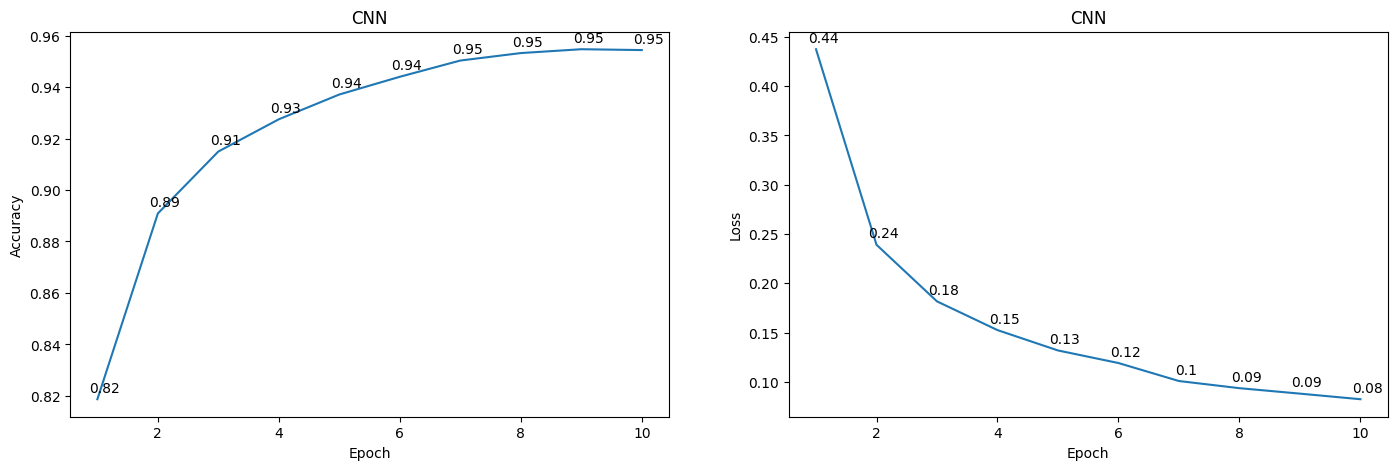

In [183]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

axes = axes.flatten()

plt.sca(axes[0])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epoch, accuracy_his)
plt.title('CNN')
for i, (xi, yi) in enumerate(zip(epoch, accuracy_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')
    
plt.sca(axes[1])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epoch, loss_his)
plt.title('CNN')
for i, (xi, yi) in enumerate(zip(epoch, loss_his)):
    plt.annotate(f'{round(yi,2)}', (xi, yi), textcoords="offset points", xytext=(5, 5), ha='center')

plt.show()

In [184]:
test_prediction = model.predict(protein_test)
test_prediction[0]

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([6.0024519e-08, 8.0008007e-04, 9.9919981e-01, 1.5677619e-10],
      dtype=float32)

In [186]:
test_pre = np.argmax(test_prediction, axis = 1)
test_label = np.argmax(label_test, axis = 1)

In [187]:
print(classification_report(test_pre, test_label))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1373
           1       0.50      0.57      0.54       263
           2       0.87      0.82      0.85       904
           3       0.99      0.99      0.99       473

    accuracy                           0.91      3013
   macro avg       0.84      0.84      0.84      3013
weighted avg       0.91      0.91      0.91      3013



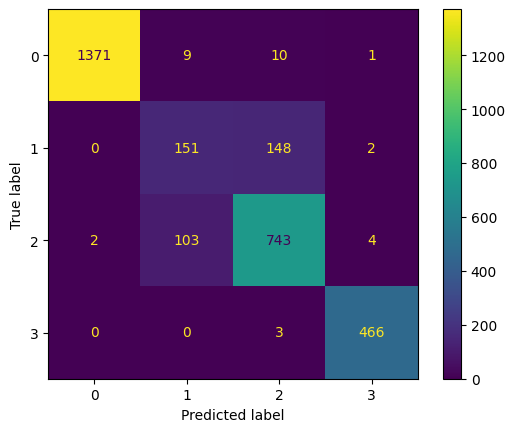

In [188]:
cm = confusion_matrix(test_label, test_pre, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
disp.plot()

# Rolling

In [ ]:

# # A simpleRNN without any pretrained embeddings and one dense layer
# optimizers = tf.keras.optimizers.Adam(learning_rate = 0.005, use_ema=True)

# cnn_lstm_model = keras.Sequential()
# # cnn_lstm_model.add(TimeDistributed(Embedding(input_dim=max_length,output_dim=8)))
# cnn_lstm_model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu')))
# cnn_lstm_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# cnn_lstm_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, activation='relu')))
# cnn_lstm_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

# cnn_lstm_model.add(layers.LSTM(units=128, activation='tanh', unit_forget_bias=False))

# cnn_lstm_model.add(Flatten())
# cnn_lstm_model.add(Dense(units=128, activation='relu'))
# cnn_lstm_model.add(Dense(units=4, activation='softmax'))

# cnn_lstm_model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

# cnn_lstm_model.summary()

In [ ]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# data_padding, label = ros.fit_resample(data_padding, train_data['label'])

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=300,max_depth=14)
# clf.fit(dna_train, label_train)

In [ ]:
# label_pre = clf.predict(dna_test)
# print(classification_report(label_pre,label_test))
# print(accuracy_score(label_pre,label_test)*100)

In [ ]:
# from sklearn.metrics import accuracy_score

# accuracy_score(test_pre, test_label)

In [ ]:
# mers_data_test = read_data('/kaggle/input/dna-sequence-testing/SARS_TEST.fasta')
# mers_data_encoding = data_preprocessing(mers_data_test)

# influenza_data_test = read_data('/kaggle/input/dna-sequence-testing/INFLUENZA_TEST.fasta')
# influenza_data_encoding = data_preprocessing(influenza_data_test)

In [ ]:
# data_test = mers_data_encoding + influenza_data_encoding[:1000]

In [ ]:
# p = pad_sequences(influenza_data_encoding, maxlen=max_length,value=0,padding='post')

In [ ]:
# data_test_padding = pad_sequences(data_test, maxlen=max_length,value=0,padding='post')

In [ ]:
# import
# loaded_model = keras.saving.load_model("model.keras")

In [ ]:
# results = model.predict(p)
# results[:3]

In [ ]:
# pre = np.argmax(results, axis = 1)
# pre[:3]

In [ ]:
# actual_results = [1] * len(mers_data_encoding) + [3] * 1000

In [ ]:
# unique, counts = np.unique(pre, return_counts=True)
# dict(zip(unique, counts))

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# typeClass = ['CNN','CNN','CNN-LSTM','CNN-LSTM']
# typeEval = ['Label Encoding Training', 'Label Encoding Testing', 'Label Encoding Training', 'Label Encoding Testing']
# accuracy = [0.96, 0.92, 0.95, 0.93]
# accuracy_table = pd.DataFrame({'type': typeClass, 'typeEval': typeEval, 'accuracy': accuracy})

# sns.barplot(data = accuracy_table, x='typeEval', y='accuracy',hue = 'type', saturation=1, palette = "mako")
# plt.xlabel('')
# plt.ylabel('Accuracy (%)')
# plt.show()